# RentListingInquries

## 基本信息
bathrooms: 浴室的数量number of bathrooms
bedrooms: 卧室数量number of bedrooms
building_id: ID号
created: 
description: 描述
display_address: 
features: 关于这间公寓的功能列表a list of features about this apartment
latitude: 纬度
listing_id
longitude: 经度
manager_id
photos: 照片链接列表a list of photo links. You are welcome to download the pictures yourselves from renthop's site, but they are the same as imgs.zip. 
price: 以美元计算in USD
street_address: 街道地址
interest_level: 这是目标变量。它有3个类别：'高'，'中等'，'低'this is the target variable. It has 3 categories: 'high', 'medium', 'low'

In [1]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV

#竞赛的评价指标为logloss
#from sklearn.metrics import log_loss  
#SVM并不能直接输出各类的概率，所以在这个例子中我们用正确率作为模型预测性能的度量
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
import seaborn as sns
#from zhou.utils_zhou import *

%matplotlib inline

## 读取数据 & 数据探索

In [2]:
# 读取数据
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"train_FE.csv")
train.head()

,bathrooms,bedrooms,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,Month,Day,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
0,1.5,3,3000,1200.0,750.000000,-1.5,4.5,2016,6,24,...,0,0,0,0,0,0,0,0,0,1
1,1.0,2,5465,2732.5,1821.666667,-1.0,3.0,2016,6,12,...,0,0,0,0,0,0,0,0,0,2
2,1.0,1,2850,1425.0,1425.000000,0.0,2.0,2016,4,17,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,3275,1637.5,1637.500000,0.0,2.0,2016,4,18,...,0,0,0,0,0,0,0,0,0,2
4,1.0,4,3350,1675.0,670.000000,-3.0,5.0,2016,4,28,...,0,0,1,0,0,0,0,0,0,2


In [3]:
train['interest_level'].value_counts()

2    34284
1    11229
0     3839
Name: interest_level, dtype: int64

In [4]:
part_0 = train[train['interest_level']==0][::7].copy()
part_1 = train[train['interest_level']==1][::20].copy()
part_2 = train[train['interest_level']==2][::60].copy()
part_0.shape, part_1.shape, part_2.shape

((549, 227), (562, 227), (572, 227))

In [5]:
train = pd.concat((part_0, part_1, part_2))
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1683 entries, 2 to 49321
Columns: 227 entries, bathrooms to interest_level
dtypes: float64(8), int64(219)
memory usage: 2.9 MB


In [6]:
# 测试数据
test = pd.read_csv(dpath+'test_FE.csv')
test.head()

,bathrooms,bedrooms,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,Month,Day,...,virtual,walk,walls,war,washer,water,wheelchair,wifi,windows,work
0,1.0,1,2950,1475.000000,1475.000000,0.0,2.0,2016,6,11,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2850,1425.000000,950.000000,-1.0,3.0,2016,6,24,...,0,0,0,1,0,0,0,0,0,0
2,1.0,1,3758,1879.000000,1879.000000,0.0,2.0,2016,6,3,...,0,0,0,0,0,0,0,0,0,0
3,1.0,2,3300,1650.000000,1100.000000,-1.0,3.0,2016,6,11,...,0,0,0,0,0,0,1,0,0,0
4,2.0,2,4900,1633.333333,1633.333333,0.0,4.0,2016,4,12,...,0,0,0,1,0,0,0,0,0,0


各类样本不均衡。交叉验证对分类任务缺省的是采用StratifiedKFold，在每折采样时根据各类样本按比例采样

# 数据量太大,分割数据

In [7]:
# 区分测试集与训练集
target = train.pop('interest_level')

from sklearn.model_selection import train_test_split
X_train_part, X_val, y_train_part, y_val = train_test_split(train, target
    , test_size=0.2
    , random_state=42
    , stratify=target)


In [8]:
X_train_part.shape, X_val.shape

((1346, 226), (337, 226))

## 模型训练

### default SVC

In [9]:
#LinearSVC不能得到每类的概率，在Otto数据集要求输出每类的概率，这里只是示意SVM的使用方法
#https://xacecask2.gitbooks.io/scikit-learn-user-guide-chinese-version/content/sec1.4.html
#1.4.1.2. 得分与概率
from sklearn.svm import LinearSVC

SVC1 = LinearSVC().fit(X_train_part, y_train_part)

In [10]:
#在校验集上测试，估计模型性能
from sklearn import metrics
y_predict = SVC1.predict(X_val)

print("Classification report for classifier %s:\n%s\n"
      % (SVC1, metrics.classification_report(y_val, y_predict)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_val, y_predict))

Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0):
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       110
          1       0.34      0.48      0.40       112
          2       0.45      0.70      0.54       115

avg / total       0.27      0.40      0.32       337


Confusion matrix:
[[ 0 68 42]
 [ 1 54 57]
 [ 0 35 80]]


In [11]:
set(y_predict)

{0, 1, 2}

### 线性SVM正则参数调优

线性SVM LinearSVC的需要调整正则超参数包括C（正则系数，一般在log域（取log后的值）均匀设置候选参数）和正则函数penalty（L2/L1） 

采用交叉验证，网格搜索步骤与Logistic回归正则参数处理类似，在此略。

这里我们用校验集（X_val、y_val）来估计模型性能

In [12]:
def fit_grid_point_Linear(C, X_train, y_train, X_val, y_val):
    
    # 在训练集是那个利用SVC训练
    SVC2 =  LinearSVC( C = C)
    SVC2 = SVC2.fit(X_train, y_train)
    
    # 在校验集上返回accuracy
    accuracy = SVC2.score(X_val, y_val)
    
    print("accuracy: {0}".format(accuracy))
    return accuracy

In [13]:
#需要调优的参数
C_s = np.logspace(-3, 3, 7)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份  
#penalty_s = ['l1','l2']

accuracy_s = []
for i, oneC in enumerate(C_s):
#    for j, penalty in enumerate(penalty_s):
    tmp = fit_grid_point_Linear(oneC, X_train_part, y_train_part, X_val, y_val)
    accuracy_s.append(tmp)


accuracy: 0.3649851632047478
accuracy: 0.43026706231454004
accuracy: 0.41543026706231456
accuracy: 0.4094955489614243
accuracy: 0.42136498516320475
accuracy: 0.3323442136498516
accuracy: 0.3293768545994065


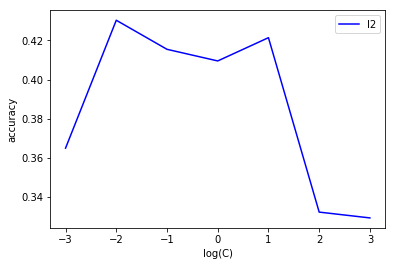

In [14]:
x_axis = np.log10(C_s)
#for j, penalty in enumerate(penalty_s):
plt.plot(x_axis, np.array(accuracy_s), 'b-', label='l2')
    
plt.xlabel( 'log(C)' )                                                                                                      
plt.ylabel( 'accuracy' )
plt.legend()
#plt.savefig('SVM_Otto.png' )

plt.show()


### RBF核SVM正则参数调优

RBF核是SVM最常用的核函数。
RBF核SVM 的需要调整正则超参数包括C（正则系数，一般在log域（取log后的值）均匀设置候选参数）和核函数的宽度gamma
C越小，决策边界越平滑； 
gamma越小，决策边界越平滑。

采用交叉验证，网格搜索步骤与Logistic回归正则参数处理类似，在此略。

这里我们用校验集（X_val、y_val）来估计模型性能

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [16]:
#需要调优的参数
# 请尝试将L1正则和L2正则分开，并配合合适的优化求解算法（slover）
#tuned_parameters = {'penalty':['l1','l2'],
#                   'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
#                   }

#需要调优的参数
C_s = np.logspace(-2, 2, 5)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份 
gamma_s = np.logspace(-2, 2, 5)  
print('C_s =', C_s)
print('gamma_s =', gamma_s)
tuned_parameters = dict(gamma=gamma_s, C = C_s)

lrSVC_penalty= SVC(kernel='rbf',probability=True)

grid= GridSearchCV(lrSVC_penalty, param_grid=tuned_parameters, cv=5, 
                   scoring='neg_log_loss', 
                   return_train_score=True, 
                   n_jobs=-1)
grid.fit(X_train_part, y_train_part,)

C_s = [1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]
gamma_s = [1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [17]:
grid.cv_results_

{'mean_fit_time': array([2.44022994, 2.38022652, 2.37702918, 2.38043752, 2.36194119,
        2.38996634, 2.38592343, 2.36921535, 2.3633955 , 2.3666142 ,
        2.39455891, 2.38406806, 2.36778927, 2.36277089, 2.36385908,
        2.40522242, 2.39435492, 2.40615172, 2.38964305, 2.39870467,
        2.40092692, 2.39878092, 2.39153686, 2.38762703, 2.33452978]),
 'std_fit_time': array([0.03211139, 0.03165316, 0.01961775, 0.03077436, 0.02510653,
        0.02671905, 0.01667146, 0.01666964, 0.01331102, 0.0143402 ,
        0.0140501 , 0.01386493, 0.01257321, 0.00965303, 0.00816511,
        0.01691828, 0.01370748, 0.01150241, 0.0150435 , 0.01571463,
        0.01213916, 0.01081066, 0.007489  , 0.01219262, 0.09324278]),
 'mean_score_time': array([0.09031763, 0.08822751, 0.088164  , 0.08784246, 0.08687534,
        0.08697276, 0.08672895, 0.08649378, 0.08601532, 0.08633327,
        0.08751841, 0.08649349, 0.08622208, 0.086448  , 0.08652153,
        0.08607907, 0.0858335 , 0.08579021, 0.08575387, 0.08

In [18]:
print(-grid.best_score_)
print(grid.best_params_)

1.0851320275299388
{'C': 10.0, 'gamma': 0.01}


从上述部分运行结果来看，gamma参数设置不合适（gamma越大，对应RBF核的sigma越小，决策边界更复杂，可能发生了过拟合）
所以调小gamma值